<a href="https://colab.research.google.com/github/RubberSoul-l/rubber/blob/master/CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

Install all the dependencies to make the most out of TorchCAM

In [1]:
!pip install torchvision matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Latest stable release

In [4]:
!pip install torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchcam-0.3.2-py3-none-any.whl (28 kB)


## From source

In [2]:
# Install the most up-to-date version from GitHub
!pip install -e git+https://github.com/frgfm/torch-cam.git#egg=torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining torchcam from git+https://github.com/frgfm/torch-cam.git#egg=torchcam
  Updating ./src/torchcam clone
  Running command git fetch -q --tags
  Running command git reset --hard -q d2a042ec71aedda2b173347de587443bde734ecb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Running setup.py develop for torchcam


Now go to `Runtime/Restart runtime` for your changes to take effect!

In [5]:
import torchcam

# Basic usage

In [1]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [4]:
# Download an image
!wget https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
# Set this to your image path if you wish to run it on your own data
img_path = "border-collie.jpg"
img_path2 = "chest.png"

--2022-09-21 05:35:21--  https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
Resolving www.woopets.fr (www.woopets.fr)... 104.26.12.50, 104.26.13.50, 172.67.73.8, ...
Connecting to www.woopets.fr (www.woopets.fr)|104.26.12.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273044 (267K) [image/jpeg]
Saving to: ‘border-collie.jpg.2’

border-collie.jpg.2 100%[===================>] 266.64K  --.-KB/s    in 0.03s   

2022-09-21 05:35:21 (10.2 MB/s) - ‘border-collie.jpg.2’ saved [273044/273044]



In [7]:
model = resnet18(pretrained=True).eval()

## Illustrate your classifier capabilities

In [ ]:
cam_extractor = SmoothGradCAMpp(model)

In [34]:
# Get your input
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [9]:
# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)

torch.Size([1, 7, 7])


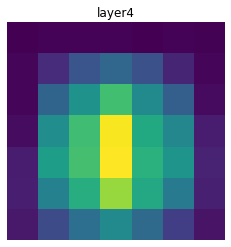

In [10]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.squeeze(0).numpy()); plt.axis('off'); plt.title(name); plt.show()

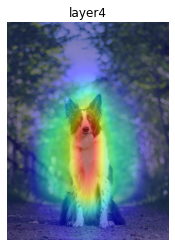

In [11]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [12]:
import cv2

In [36]:
image = cv2.imread(img_path2)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_three = cv2.merge([gray,gray,gray])

In [37]:
img = Image.open(img_path2)
rgbimg = Image.new("RGB", img.size)
rgbimg.paste(img)
rgbimg.save('foo.jpg')

In [38]:
rgbimg = read_image('foo.jpg')

torch.Size([1, 7, 7])


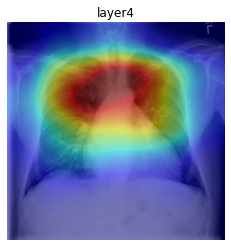

In [39]:
# Preprocess it for your chosen model
input_tensor = normalize(resize(rgbimg, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.squeeze(0).numpy()); plt.axis('off')
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(rgbimg), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [40]:
with open('labels.txt') as f:
    labels = [line.strip() for line in f.readlines()]

_, index = torch.max(out, 1)

percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

print(labels[index[0]], percentage[index[0]].item())
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

viaduct 29.011144638061523


[('viaduct', 29.011144638061523),
 ('fountain', 27.528432846069336),
 ('castle', 5.496448040008545),
 ('church, church building', 4.827864646911621),
 ('beacon, lighthouse, beacon light, pharos', 2.3723185062408447)]

In [44]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

# Advanced tricks

## Extract localization cues

In [41]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
print(softmax(out, dim=1).max())

RuntimeError: ignored

In [42]:
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [43]:
# Resize it
resized_cams = [resize(to_pil_image(cam.squeeze(0)), img.shape[-2:]) for cam in cams]
segmaps = [to_pil_image((resize(cam, img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# Plot it
for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
  _, axes = plt.subplots(1, 2)
  axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
  axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
  plt.show()

AttributeError: ignored

In [ ]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

## Fuse CAMs from multiple layers

In [ ]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model, ["layer2", "layer3", "layer4"])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
# This time, there are several CAMs
for cam in cams:
  print(cam.shape)

In [ ]:
# The raw CAM
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.squeeze(0).numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

In [ ]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.squeeze(0).numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

In [ ]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()